In [16]:
import math
import base64
import io
import json
import random
from itertools import product, combinations
from pathlib import Path
from collections import Counter
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import torch
from tensorboard.backend.event_processing import event_accumulator
from sklearn.cluster import SpectralClustering, DBSCAN
from plotnine import *
import magicsoup as ms
from e1_co2_fixing.chemistry import CHEMISTRY

theme_set(theme_minimal())
THIS_DIR = Path(".") / "e1_co2_fixing"
RUNS_DIR = THIS_DIR / "runs"

In [3]:
def load_hparams(runs_glob: str) -> pd.DataFrame:
    records = []
    for hparams_file in RUNS_DIR.glob(f"{runs_glob}/hparams.json"):
        run_dir = hparams_file.parent
        with open(hparams_file) as fh:
            hparams = json.load(fh)
        name = run_dir.name
        run = "_".join(name.split("_")[:-1])
        trial = name.split("_")[-1]
        records.append({**hparams, "run": run, "trial": trial, "name": name})

    return pd.DataFrame.from_records(records)

def load_scalars(runs_glob: str, scalars: list[tuple[str, str]]) -> pd.DataFrame:
    records = []
    for event_file in RUNS_DIR.glob(f"{runs_glob}/*.out.tfevents.*"):
        for tag, scalar in scalars:
            name = event_file.parent.name
            tf_ea = event_accumulator.EventAccumulator(str(event_file))
            tf_ea.Reload()
            for obj in tf_ea.Scalars(tag):
                records.append(
                    {
                        "name": name,
                        "scalar": scalar,
                        "value": obj.value,
                        "step": obj.step,
                    }
                )
    return pd.DataFrame.from_records(records)

def find_diffs(df: pd.DataFrame, name="name", step="step", val="value") -> pd.DataFrame:
    records = []
    for _, df in df.groupby(name):
        s = df[val].diff(periods=1)
        records.extend(df.loc[s > 0.0, [step, val, name]].to_dict("records"))
    return pd.DataFrame.from_records(records)

def find_steps(run_dir: Path) -> list[int]:
    steps = [int(d.name.split("step=")[-1]) for d in run_dir.glob("step=*")]
    return sorted(steps)

In [6]:
runs_glob = "2023-05-*"
scalars = [
    ("Cells/total", "cells"),
    ("Cells/Generation", "generation"),
    ("Cells/Survival", "survival"),
    ("Other/Phase", "phase"),
    ("Other/Split", "split"),
    ("Other/MutationRate", "mutations"),
    ("Other/Score", "score"),
]

hparams_df = load_hparams(runs_glob=runs_glob)
scalars_df = load_scalars(runs_glob=runs_glob, scalars=scalars)
phases_df = find_diffs(scalars_df.loc[scalars_df["scalar"] == "phase"])
splits_df = find_diffs(scalars_df.loc[scalars_df["scalar"] == "split"])

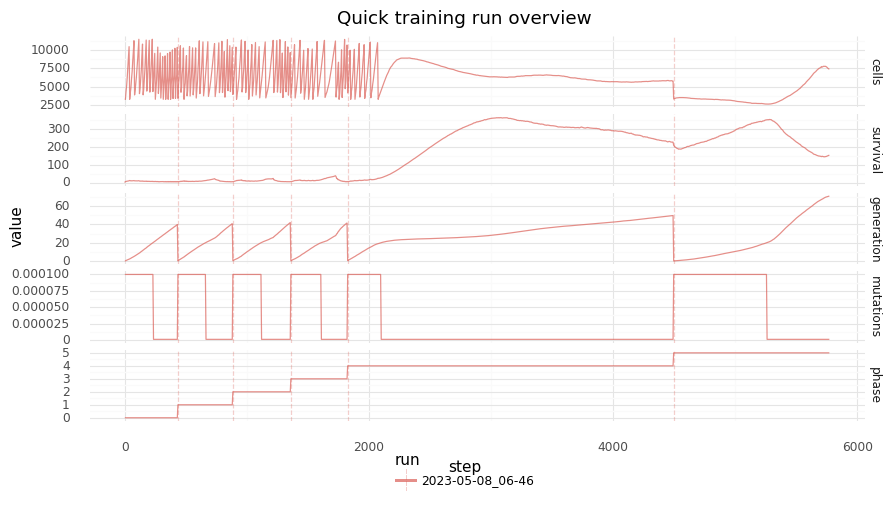

<ggplot: (8763879705610)>

In [11]:
scalars = ["cells", "survival", "generation", "mutations", "phase"]
df = scalars_df[scalars_df["scalar"].isin(scalars)].copy()
df["scalar"] = pd.Categorical(df["scalar"], categories=scalars, ordered=True)
df = df.merge(hparams_df[["run", "trial", "name"]], on="name")
df1 = phases_df.merge(hparams_df[["run", "trial", "name"]], on="name")

(ggplot(df)
    + geom_vline(aes(xintercept="step", color="run"), alpha=0.3, linetype="dashed", data=df1)
    + geom_line(aes(y="value", x="step", group="name", color="run"), alpha=0.7)
    + facet_grid("scalar ~ .", scales="free")
    + theme(figure_size=(10, 5), legend_position="bottom")
    + ggtitle("Quick training run overview"))

In [12]:
world = ms.World.from_file(rundir=RUNS_DIR, device="cpu")
mol_2_idx = {d.name: i for i, d in enumerate(world.chemistry.molecules)}

In [13]:
run_name = "2023-05-08_06-46_0"
steps = find_steps(RUNS_DIR / run_name)
step = steps[-1]
world.load_state(statedir=RUNS_DIR / run_name / f"step={step}")
print(f"{world.n_cells:,} cells at step {step:,}")

7,636 cells at step 5,750


In [27]:
def get_proteome_doms(cell: ms.Cell) -> list[list[str]]:
    proteome_strs = []
    for protein in cell.proteome:
        domstrs = []
        for dom in protein.domains:
            if isinstance(dom, ms.TransporterDomain):
                domstrs.append(f"{dom.molecule} [trnsp]")
            if isinstance(dom, ms.CatalyticDomain):
                subs = " + ".join(sorted(d.name for d in dom.substrates))
                prods = " + ".join(sorted(d.name for d in dom.products))
                domstrs.append(" <-> ".join(sorted([subs, prods])))
            if isinstance(dom, ms.RegulatoryDomain):
                domstrs.append(f"{dom.effector} [reg]")
        proteome_strs.append(domstrs)
    return proteome_strs


In [41]:
n_cells = world.n_cells
proteomes = [get_proteome_doms(world.get_cell(by_idx=d)) for d in range(n_cells)]

In [45]:
cell_features = []
for prots in proteomes:
    cell_features.append(set(d for p in prots for d in p))

feature_counts = Counter(d for doms in cell_features for d in doms)
sorted_features = sorted((d, k) for k, d in feature_counts.items())

records = []
rng_idxs = list(range(n_cells))
for _, feat in reversed(sorted_features):
    n = sum(1 for i in rng_idxs if feat in cell_features[i])
    records.append({"feature": feat, "n": n})
df = pd.DataFrame.from_records(records)
df["freq"] = df["n"] / n_cells
df["type"] = "catal-dom"
df.loc[df["feature"].str.endswith("[trnsp]"), "type"] = "trnsp-dom"
df.loc[df["feature"].str.endswith("[reg]"), "type"] = "reg-dom"

df[df["freq"] > 0.7].sort_values(by="type")["feature"]

1         HS-CoA + X + X + X + X + X <-> acetyl-CoA
2                      FH4 + formate <-> formyl-FH4
4     CO + HS-CoA + methyl-FH4 <-> FH4 + acetyl-CoA
7        NADP + methylen-FH4 <-> NADPH + formyl-FH4
8        NADP + methyl-FH4 <-> NADPH + methylen-FH4
10                               E + NADP <-> NADPH
0                                         E [trnsp]
3                                    HS-CoA [trnsp]
5                                       FH4 [trnsp]
6                                      NADP [trnsp]
9                                   formate [trnsp]
Name: feature, dtype: object

In [36]:
cell = world.get_cell(by_idx=4000)
proteome = get_proteome_doms(cell=cell)
for prot in proteome:
    reacts = [d for d in prot if "<->" in d]
    if len(reacts) > 0:
        print(", ".join(reacts))

E + NADP <-> NADPH
NADP + methyl-FH4 <-> NADPH + methylen-FH4
NADP + methyl-FH4 <-> NADPH + methylen-FH4
NADP + methyl-FH4 <-> NADPH + methylen-FH4
HS-CoA + X + X + X + X + X <-> acetyl-CoA, FH4 + formate <-> formyl-FH4
HS-CoA + X + X + X + X + X <-> acetyl-CoA, FH4 + formate <-> formyl-FH4
CO + NADP <-> CO2 + NADPH
CO + HS-CoA + methyl-FH4 <-> FH4 + acetyl-CoA
CO + HS-CoA + methyl-FH4 <-> FH4 + acetyl-CoA
E + NADP <-> NADPH
NADP + methyl-FH4 <-> NADPH + methylen-FH4
NADP + methyl-FH4 <-> NADPH + methylen-FH4
NADP + methyl-FH4 <-> NADPH + methylen-FH4
HS-CoA + X + X + X + X + X <-> acetyl-CoA
CO + HS-CoA + methyl-FH4 <-> FH4 + acetyl-CoA
HS-CoA + acetoacetyl-CoA <-> acetyl-CoA + acetyl-CoA
CO + HS-CoA + methyl-FH4 <-> FH4 + acetyl-CoA
CO + HS-CoA + methyl-FH4 <-> FH4 + acetyl-CoA
CO + NADP <-> CO2 + NADPH
NADP + methylen-FH4 <-> NADPH + formyl-FH4
NADP + methylen-FH4 <-> NADPH + formyl-FH4
FH4 + formate <-> formyl-FH4
FH4 + formate <-> formyl-FH4
CO + HS-CoA + methyl-FH4 <-> FH4 + acet

In [29]:
cell_doms

[['HS-CoA + X + X + X + X + X <-> acetyl-CoA'],
 ['HS-CoA [trnsp]'],
 ['NADP + hydroxybutyryl-CoA <-> NADPH + acetoacetyl-CoA',
  'hydroxybutyryl-CoA [reg]'],
 ['NADP + hydroxybutyryl-CoA <-> NADPH + acetoacetyl-CoA',
  'hydroxybutyryl-CoA [reg]'],
 ['3PGA [trnsp]'],
 ['3PGA [trnsp]'],
 ['FH4 + formate <-> formyl-FH4'],
 ['CO + HS-CoA + methyl-FH4 <-> FH4 + acetyl-CoA'],
 ['CO + HS-CoA + methyl-FH4 <-> FH4 + acetyl-CoA'],
 ['FH4 [trnsp]'],
 ['FH4 [trnsp]'],
 ['FH4 [trnsp]'],
 ['FH4 [trnsp]'],
 ['propionyl-CoA [trnsp]'],
 ['propionyl-CoA [trnsp]'],
 ['NADP [trnsp]'],
 ['3PGA [trnsp]'],
 ['3PGA [trnsp]'],
 ['3PGA [trnsp]'],
 ['malyl-CoA [reg]', 'HS-CoA + succinate <-> succinyl-CoA'],
 ['HS-CoA + succinate <-> succinyl-CoA'],
 ['NADP + NADP + NADP + propionyl-CoA <-> NADPH + NADPH + NADPH + malonyl-CoA']]

In [21]:
clustering = SpectralClustering(n_clusters=5, n_init=20).fit(world.kinetics.N)
A = clustering.affinity_matrix_

ValueError: Found array with dim 3. SpectralClustering expected <= 2.